# Training the encoder using GAN

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


# to import MNIST as torch tensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

In [2]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 100
lr = 1e-4
# how many epochs for training
num_epochs = 40
# latent space size
z_dim = 10

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [3]:
# create an encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, z_dim)
        )

    def forward(self, img):
        img_flat = img.view(-1, 28*28)
        z = self.model(img_flat)
        return z

In [4]:
# create a decoder/generation
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(z_dim, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 28*28),
            nn.Tanh(),
        )

    def forward(self, z):
        img_flat = self.model(z)
        img = img_flat.view(-1, 28, 28)
        return img

In [5]:
# create a discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

In [6]:
# build a GAN model
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

# set loss function
auto_criterion = torch.nn.MSELoss()
gan_criterion = torch.nn.L1Loss()

# choose an optimizer
e_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=1e-5)
d_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr, weight_decay=1e-5)
g_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=1e-5)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr,weight_decay=1e-5)


print(encoder, decoder, discriminator)

Encoder(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=100, bias=True)
    (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
) Decoder(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=100, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=784, bias=True)
    (6): Tanh()
  )
) Discriminator(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=

In [7]:
### Training the model
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        
        ## Training the autoencoder
        #--------------------------
        # forward path
        output = decoder(encoder(img))
        loss_auto = auto_criterion(output, img)
        # back propagation
        e_optimizer.zero_grad()
        d_optimizer.zero_grad()
        loss_auto.backward()
        e_optimizer.step()
        d_optimizer.step()
        
        ## generating data for discriminator
        #-----------------------------------
        encoder.eval()
        z_real = torch.randn(batch_size, z_dim)
        z_fake = encoder(img)
        
        ## Training the discriminator
        #----------------------------
        # forward path
        real_output = discriminator(z_real)
        fake_output = discriminator(z_fake)
        d_loss = 0.5*(auto_criterion(real_output + 0.001, torch.ones(real_output.size(), requires_grad = False) + 0.001)
                       +auto_criterion(fake_output, torch.zeros(fake_output.size(), requires_grad = False)))
        # back propagation
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        ## optimize the generator
        #------------------------
        encoder.train()
        z_fake = encoder(img)
        fake_output = discriminator(z_fake)
        g_loss = auto_criterion(fake_output + 0.001, torch.ones(fake_output.size(), requires_grad = False)+ 0.001)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()


        # log
    print('epoch [{}/{}], autoencoder loss:{:.4f}, discriminator loss:{:.4f}, generator loss:{:.4f}'
          .format(epoch+1, num_epochs, loss_auto.item(), d_loss.item(), g_loss.item()))

C:\Users\Hassan\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([100, 1, 28, 28])) that is different to the input size (torch.Size([100, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch [1/40], autoencoder loss:0.1855, discriminator loss:0.2120, generator loss:0.3386
epoch [2/40], autoencoder loss:0.1723, discriminator loss:0.1775, generator loss:0.5018
epoch [3/40], autoencoder loss:0.2146, discriminator loss:0.2592, generator loss:0.1360
epoch [4/40], autoencoder loss:0.1846, discriminator loss:0.2704, generator loss:0.1931
epoch [5/40], autoencoder loss:0.1932, discriminator loss:0.2497, generator loss:0.1890
epoch [6/40], autoencoder loss:0.2103, discriminator loss:0.2621, generator loss:0.2400
epoch [7/40], autoencoder loss:0.2093, discriminator loss:0.2167, generator loss:0.2751
epoch [8/40], autoencoder loss:0.2009, discriminator loss:0.2501, generator loss:0.3044
epoch [9/40], autoencoder loss:0.2014, discriminator loss:0.2205, generator loss:0.3958
epoch [10/40], autoencoder loss:0.1906, discriminator loss:0.2227, generator loss:0.3678
epoch [11/40], autoencoder loss:0.1914, discriminator loss:0.2444, generator loss:0.3953
epoch [12/40], autoencoder los

## visualizing reconstructed results
### NOTE TO SELF: to be automated through DV

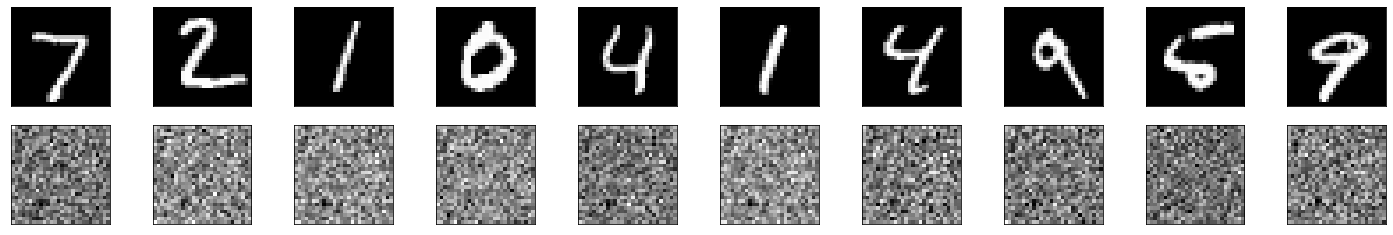

In [10]:
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = decoder(encoder(images))
# prep images for display
images = images.numpy() # output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()